In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

## Funções

In [336]:
def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

def rosenbrock(x, n):
    return sum(100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(n-1))

In [337]:
def grad_himmelblau(x):
    return [4*x[0]**3 + 4*x[0]*x[1] -42*x[0] + 2*x[1]**2 -14,
            4*x[1]**3 + 4*x[0]*x[1] -26*x[1] + 2*x[0]**2 -22]

def first_grad_rosenbrock(x):
    return 400*x[0]**3 + 2*x[0] - 400*x[1]*x[0] - 2

def last_grad_rosenbrock(x):
    return 200*x[-1] - 200*x[-2]**2

def middle_grad_rosenbrock(x,i):
    return 400*x[i]**3 + 202*x[i] - 400*x[i+1]*x[i] - 200*x[i-1]**2 - 2

def grad_rosenbrock(x,n):
    
    grad = []

    if n == 1:
        return IndexError 
    if n == 2:
        grad.append(first_grad_rosenbrock(x))
        grad.append(last_grad_rosenbrock(x))
        return grad
    else:
        grad.append(first_grad_rosenbrock(x))
        
        for i in range(1,n-1):
            grad.append(middle_grad_rosenbrock(x,i))  

        grad.append(last_grad_rosenbrock(x))
    
    return grad

In [7]:
# Hessians
def hess_himmelblau(x, n=2):

    return [[8*x[0]**2 + 4 * (x[0]**2 + x[1] - 11) + 2,  4 * (x[0] + x[1])],
            [4 * (x[0] + x[1]),                          8*x[1]**2 + 4 * (x[0] + x[1]**2 - 7) + 2]]

def hess_rosenbrock(x,n):
    if n == 1:
        return IndexError

    hess = np.zeros((n,n))

    hess[0,0] = 1200*x[0]**2 - 400*x[1] + 2
    hess[0,1] = -400*x[0]
    hess[1,0] = -400*x[0]

    for i in range(1,n-1):
        hess[i,i] = 1200*x[i]**2 - 400*x[i+1] + 202
        # hess[i,i-1] = -400*x[i-1]
        hess[i+1,i] = -400*x[i] 

    hess[-1,-1] = 200

    return hess

In [32]:
def line_search(func, grad, x, d):
    alpha = 1.0
    c = 0.3  # Constante de Armijo
    rho = 0.5  # Fator de redução
    while func(x + alpha * d) > func(x) + c * alpha * np.dot(grad(x), d):
        alpha *= rho

    return alpha

## Busca linear por Armijo

condição: $$ f(x + \alpha \cdot d) \le f(x) + c \cdot  \alpha  \nabla f(x)^T \cdot d $$


In [177]:
def f(x):
    return x - 2 * x**3 + x**4

# Derivada da função
def df(x):
    return 1 - 6 * x**2 + 4 * x**3


# Função de busca de linha usando o método de Armijo
def line_search(func, grad, x, d):
    alpha = 1.0
    c = 0.3  # Constante de Armijo
    rho = 0.5  # Fator de redução
    
    # Lista para armazenar os pontos x encontrados
    xs = [x]
    alphas = [alpha]
    
    while func(x + alpha * d) > func(x) + c * alpha * np.dot(grad(x), d):
        alpha *= rho
        xs.append(x + alpha * d)  # Armazena os pontos x encontrados
        alphas.append(alpha)
    return xs, alphas

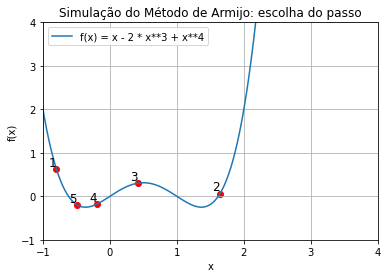

In [180]:

# Parâmetros da simulação
x_initial = -0.8 # Ponto inicial
d_initial = -df(x_initial)  # Direção de descida inicial

# Encontra os pontos x e alpha usando a função line_search
x_values = line_search(f, df, x_initial, d_initial)[0]
alphas = line_search(f, df, x_initial, d_initial)[1]

# Plotagem da função e das retas tangentes
x_range = np.linspace(-2, 4, 400)
plt.plot(x_range, f(x_range), label='f(x) = x - 2 * x**3 + x**4')

for i, x in enumerate(x_values):
    plt.scatter(x, f(x), color='red')
    plt.text(x, f(x), str(i+1), verticalalignment='bottom', horizontalalignment='right', fontsize=12)
plt.title('Simulação do Método de Armijo: escolha do passo')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-1, 4)
plt.xlim(-1, 4) 
plt.legend()
plt.grid(True)
plt.show()

Isto significa que procuramos um passo cuja redução na função seja pelo menos
uma fração c da redução obtida no modelo linear. 

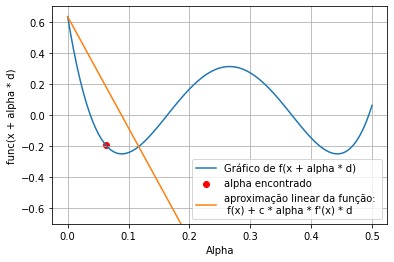

In [184]:
# Define o intervalo de alphas


alpha_range = np.linspace(0, 0.5, 100)
def teta(alpha):
    return f(x_initial + alpha * d_initial)

def dteta(alpha):
    return f(x_initial) + 0.3 * alpha * np.dot(df(x_initial), d_initial)
# Encontra os valores da função para diferentes alphas
y_values = [teta(alpha) for alpha in alpha_range]

y_values_tangente = [ dteta(alpha) for alpha in alpha_range] 

# Plotagem da função func(x + alpha * d) para todo alpha
plt.plot(alpha_range, y_values, label='Gráfico de f(x + alpha * d)')
plt.scatter(alphas[4], teta(alphas[4]), color='red', label='alpha encontrado')
plt.plot(alpha_range, y_values_tangente, label='aproximação linear da função: \n f(x) + c * alpha * f\'(x) * d')
plt.xlabel('Alpha')
plt.ylabel('func(x + alpha * d)')
plt.ylim(-0.7, 0.7)
plt.grid(True)
plt.legend()
plt.show()

## Gradiente Conjugado




In [494]:
import time
def conjugate_gradient(func, grad, x0, tol=1e-5, max_iter=1000, q=10):
    
    cnt_iter = 0
    restart_counter = 0
    x = np.array(x0)
    x_values = [x]
    g = np.array(grad(x))
    grads = [g]
    
    start_it_time = time.time()
    start_time = time.time()
    times = []
    
    
    d = - g
    for _ in range(max_iter):
        cnt_iter +=1
        restart_counter += 1
        alpha = line_search(func, grad, x, d) 
        x = x + d*alpha
        x_values.append(x)
        g_prev = g
        g = np.array(grad(x))
        grads.append(g)
        if np.linalg.norm(g) < tol:
            total_time = time.time() - start_time
            return x, cnt_iter, x_values, np.array(times), total_time, grads
        betai = np.dot((g - g_prev).T, g) / np.dot(g_prev.T, g_prev)
        d = - g + betai*d
        times.append(time.time() - start_it_time)
        start_it_time = time.time()

    total_time = time.time() - start_time
    return x, cnt_iter, x_values, np.array(times), total_time, grads


def line_search(func, grad, x, d):
    alpha = 1.0
    c = 0.3  # Constante de Armijo
    rho = 0.01  # Fator de redução
    
    # Lista para armazenar os pontos x encontrados
    
    while func(x + alpha * d) > func(x) + c * alpha * np.dot(grad(x), d):
        alpha *= rho
    return alpha

### himmelblau
<hr/>


$ f(3.0,2.0)=0.0 \\$
$ f(−2.805118, 3.131312) = 0.0 \\$
$ f(−3.779310,−3.283186) = 0.0 \\ $
$ f(3.584428, −1.848126) = 0.0 \\$




In [542]:
x0 = [0, 0]
sol1 = conjugate_gradient(himmelblau, grad_himmelblau, x0, max_iter=1000)

x0 = [-1, -1]
sol2 = conjugate_gradient(himmelblau, grad_himmelblau, x0, max_iter=1000)

x0 = [1.5, -2]
sol3 = conjugate_gradient(himmelblau, grad_himmelblau, x0, max_iter=1000)

x0 = [-2,  1]
sol4 = conjugate_gradient(himmelblau, grad_himmelblau, x0, max_iter=1000)

In [543]:
data = {
    'x0 = [0, 0]': {
        'n_iter': sol1[1],
        'mean_time_per_iter': sol1[3].mean(),
        'total_time':  sol1[4],
        'solução': sol1[0]
    },
    'x0 = [-1, -1]': {
        'n_iter': sol2[1],
        'mean_time_per_iter': sol2[3].mean(),
        'total_time':  sol2[4],
        'solução': sol2[0]
    }, 
    'x0 = [1.5, -2]': {
        'n_iter': sol3[1],
        'mean_time_per_iter': sol3[3].mean(),
        'total_time':  sol3[4],
        'solução': sol3[0]
    }, 
    'x0 = [-2,  1]': {
        'n_iter': sol4[1],
        'mean_time_per_iter': sol4[3].mean(),
        'total_time':  sol4[4],
        'solução': sol4[0]
    },
    
    
}

pd.DataFrame(data)

,"x0 = [0, 0]","x0 = [-1, -1]","x0 = [1.5, -2]","x0 = [-2, 1]"
n_iter,66,24,50,27
mean_time_per_iter,0.000123,0.000087,0.000063,0.000083
total_time,0.007998,0.001998,0.003106,0.002147
solução,"[2.999999875653429, 2.0000003001990767]","[-3.7793102506171996, -3.2831859660637326]","[3.5844283148606233, -1.8481262479067537]","[-2.8051179672168547, 3.131312493525012]"


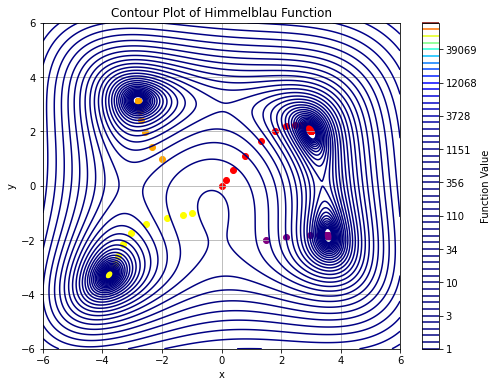

In [544]:

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(8, 6))
 
x = np.linspace(-6, 6, 400)
y = np.linspace(-6, 6, 400)
X, Y = np.meshgrid(x, y)
Z = himmelblau([X, Y])
# Drawing the contour plot
plt.contour(X, Y, Z, levels=np.logspace(0, 5, 50), cmap='jet')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot of Himmelblau Function')
plt.colorbar(label='Function Value')
plt.grid(True)

ac = ax.scatter([], [], color='red')
bc = ax.scatter([], [], color='yellow')
cc = ax.scatter([], [], color='purple')
dc = ax.scatter([], [], color='orange')


def plot_solution(frame):
    if frame < len(sol1[2]):
        ac.set_offsets(sol1[2][:frame+1])
        
    if frame < len(sol2[2]):
        bc.set_offsets(sol2[2][:frame+1])
        
    if frame < len(sol3[2]):
        cc.set_offsets(sol3[2][:frame+1])
        
    if frame < len(sol4[2]):
        dc.set_offsets(sol4[2][:frame+1])
    return ac,
    # Creating a grid of points
    
anim = FuncAnimation(fig, plot_solution, frames=len(sol1[2])+1, interval=50, blit=True)
anim.save('himmelblau_animation.gif', writer='pillow', fps=1)

### rosenbrock n=2
<hr/>

ponto ótimo: x = 1


In [580]:
def rosenbrock2(x):
    return rosenbrock(x, 2)

In [581]:
x0 = [0, 0]
sol1 = conjugate_gradient(rosenbrock2, lambda x: grad_rosenbrock(x, 2), x0, max_iter=10000)

x0 = [-1, -1]
sol2 = conjugate_gradient(rosenbrock2, lambda x: grad_rosenbrock(x, 2), x0, max_iter=10000)

x0 = [1.5, -2]
sol3 = conjugate_gradient(rosenbrock2, lambda x: grad_rosenbrock(x, 2), x0, max_iter=10000)

x0 = [-2,  1]
sol4 = conjugate_gradient(rosenbrock2, lambda x: grad_rosenbrock(x, 2), x0, max_iter=10000)

In [582]:
data = {
    'x0 = [0, 0]': {
        'n_iter': sol1[1],
        'mean_time_per_iter': sol1[3].mean(),
        'total_time':  sol1[4],
        'solução': sol1[0]
    },
    'x0 = [-1, -1]': {
        'n_iter': sol2[1],
        'mean_time_per_iter': sol2[3].mean(),
        'total_time':  sol2[4],
        'solução': sol2[0]
    }, 
    'x0 = [1.5, -2]': {
        'n_iter': sol3[1],
        'mean_time_per_iter': sol3[3].mean(),
        'total_time':  sol3[4],
        'solução': sol3[0]
    }, 
    'x0 = [-2,  1]': {
        'n_iter': sol4[1],
        'mean_time_per_iter': sol4[3].mean(),
        'total_time':  sol4[4],
        'solução': sol4[0]
    },
    
    
}

pd.DataFrame(data)

,"x0 = [0, 0]","x0 = [-1, -1]","x0 = [1.5, -2]","x0 = [-2, 1]"
n_iter,2986,3146,3385,2942
mean_time_per_iter,0.000061,0.000046,0.000046,0.000056
total_time,0.182385,0.144306,0.156237,0.166043
solução,"[0.9999896863872255, 0.9999793235887517]","[0.9999934610053115, 0.9999868794337329]","[0.9999941786890337, 0.9999883155790809]","[0.9999928369787633, 0.9999856620709704]"


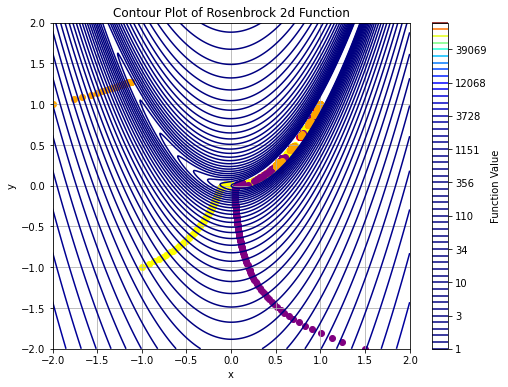

In [583]:
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(8, 6))
 
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbrock2([X, Y])
# Drawing the contour plot
plt.contour(X, Y, Z, levels=np.logspace(0, 5, 50), cmap='jet')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot of Rosenbrock 2d Function')
plt.colorbar(label='Function Value')
plt.grid(True)

ac = ax.scatter([], [], color='red')
bc = ax.scatter([], [], color='yellow')
cc = ax.scatter([], [], color='purple')
dc = ax.scatter([], [], color='orange')


num_frames = 100
step = max(1, len(sol1[2]) // num_frames)

def plot_solution(frame):
    frame_index = frame * step
    ac.set_offsets(sol1[2][:frame_index+1])
    bc.set_offsets(sol2[2][:frame_index+1])
    cc.set_offsets(sol3[2][:frame_index+1])
    dc.set_offsets(sol4[2][:frame_index+1])
    return ac,
    # Creating a grid of points
    
anim = FuncAnimation(fig, plot_solution, frames=num_frames, interval=50, blit=True)
anim.save('Rosenbrock_animation.gif', writer='pillow', fps=1)

### rosenbrock n=10
<hr/>

ponto ótimo: x = 1

In [561]:
def rosenbrock10(x):
    return rosenbrock(x, 10)

In [577]:
x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sol1 = conjugate_gradient(rosenbrock10, lambda x: grad_rosenbrock(x, 10), x0, max_iter=10000)

x0 = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
sol2 = conjugate_gradient(rosenbrock10, lambda x: grad_rosenbrock(x, 10), x0, max_iter=10000)

x0 = [-10, 10, -10, 10, -10, 10, -10, 10, -10, 10]
sol3 = conjugate_gradient(rosenbrock10, lambda x: grad_rosenbrock(x, 10), x0, max_iter=10000)

x0 = [-2,  1, -2,  1, -2,  1, -2,  1, -2,  1]
sol4 = conjugate_gradient(rosenbrock10, lambda x: grad_rosenbrock(x, 10), x0, max_iter=10000)

In [578]:
data = {
    'x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]': {
        'n_iter': sol1[1],
        'mean_time_per_iter': sol1[3].mean(),
        'total_time':  sol1[4],
        'solução': sol1[0]
    },
    'x0 = [-10, 10, -10, 10, -10, 10, -10, 10, -10, 10]': {
        'n_iter': sol2[1],
        'mean_time_per_iter': sol2[3].mean(),
        'total_time':  sol2[4],
        'solução': sol2[0]
    }, 
    'x0 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]': {
        'n_iter': sol3[1],
        'mean_time_per_iter': sol3[3].mean(),
        'total_time':  sol3[4],
        'solução': sol3[0]
    }, 
    'x0 = [-2,  1, -2,  1, -2,  1, -2,  1, -2,  1]': {
        'n_iter': sol4[1],
        'mean_time_per_iter': sol4[3].mean(),
        'total_time':  sol4[4],
        'solução': sol4[0]
    },
    
    
}

pd.DataFrame(data)

,"x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","x0 = [-10, 10, -10, 10, -10, 10, -10, 10, -10, 10]","x0 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","x0 = [-2, 1, -2, 1, -2, 1, -2, 1, -2, 1]"
n_iter,7971,6808,8009,7074
mean_time_per_iter,0.000179,0.000142,0.000152,0.000171
total_time,1.430848,0.968504,1.217492,1.213532
solução,"[0.9999999902572902, 0.999999971903201, 0.9999...","[0.9999999682841159, 0.9999999420887103, 0.999...","[0.9999999813380259, 0.9999999569950656, 0.999...","[0.9999999837069816, 0.9999999606649543, 0.999..."
